In [48]:
#!/usr/bin/env python
# coding: utf-8

# ## 03 Feature Extraction

# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import fnmatch
import yaml
import sys

from utils import *
from models import EEGEncoder
from train import train
from evaluate import evaluate

np.set_printoptions(threshold=sys.maxsize)


# Check GPU availability
# from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu())
device = torch.device('cpu')
print("Configured device: ", device)


Configured device:  cpu


#############Configuration#################
par: par1
round: 1
file: 1-par1
fmin 0.01
fmax 4.0
task perception
electrode_zone: O
electrodes [14, 15]
##############################
Xshape (150, 2, 49)
yshape (150,)


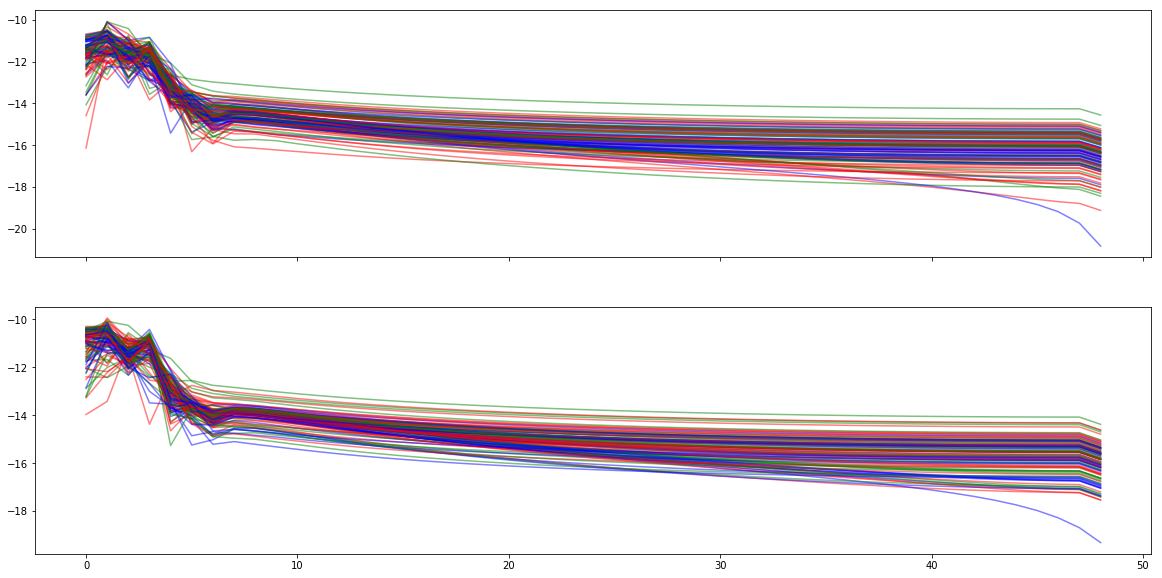

In [49]:

# 1. Loading Data
electrode_zones = {
                    "F" : "[0,1,2,3]",
                    "P" : "[4,5]",
                    "T" : "[6,7,12,13]",
                    "Fp" : "[8,9]",
                    "C" : "[10,11]",
                    "O" : "[14,15]",
                    "all" : "[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]",
}
par = 'par1'
file = '1-par1'
fmin = 0.01
fmax = 4.0
task = 'perception'
electrode_zone = 'O'
electrodes = [int(i) for i in electrode_zones[electrode_zone].replace('[', ' ').replace(']', ' ').replace(',', ' ').split()]
model_name = "cnn"
roundno = 1

print("#############Configuration#################")
print("par:", par)
print("round:", roundno)
print("file:", file)
print("fmin", fmin)
print("fmax", fmax)
print("task", task)
print("electrode_zone:", electrode_zone)
print("electrodes", electrodes)
print("##############################")



X_ = np.load('../../data/participants/{par}/02_ArtifactRemoval_Epoching_psd/{file}_{task}_{fmin}_{fmax}_X.npy'.format(par=par,file=file, task=task,fmin = fmin, fmax = fmax), allow_pickle=True)

X = get_electrode(X_,electrodes)

y = np.load('../../data/participants/{par}/02_ArtifactRemoval_Epoching_psd/{file}_{task}_{fmin}_{fmax}_y.npy'.format(par=par,file=file, task=task,fmin = fmin, fmax = fmax), allow_pickle=True)


# 1.1 Check shape
# [# stim, # electrod, # datapoint]

print('Xshape',X.shape)
print('yshape',y.shape)


# 1.2 Plot
### Plot to see wheter eegs have drift or not
def inspect_wave(_x, _y, sample=10):
    fig, ax = plt.subplots(_x.shape[1],1,figsize=(20,_x.shape[1]*5),sharex=True)

    for s in range(sample):
        if _y[s] == 0: c = 'r'
        elif _y[s] == 1: c = 'g'
        else: c = 'b'
        for i in range(_x.shape[1]):
            ax[i].plot(_x[s][i], c=c, alpha=.5)

inspect_wave(X, y, 100)


In [50]:
# 2. Reserve data for Real TEST
# - test_size: 0.1
# - 10% of data is reserved for the real test --> X_test, y_test
# - 90% will be again divided into (train,test,val) --> X_model, y_model

# <img src="img/Split.jpg" width=300 height=300 />

# 2.1 Reserve some data for REAL TEST
from sklearn.model_selection import train_test_split

X_model, X_real_test, y_model, y_real_test = train_test_split( X, y, test_size=0.1, random_state=42, stratify= y)


# Check if number of classes is equal
check_split(X_model, X_real_test, y_model, y_real_test,'model','real test')



==================== model ====================
Shape of X_model:  (135, 2, 49)
Shape of y_model:  (135,)
Classes of y_model:  [0 1 2]
Counts of y_model classes:  [45 45 45]
==================== real test ====================
Shape of X_real test:  (15, 2, 49)
Shape of y_real test:  (15,)
Classes of y_real test:  [0 1 2]
Counts of y_real test classes:  [5 5 5]


In [51]:

# 3. Prepare Train Val Test Data 

# - 10 can be thought of as totally new eeg records and will be used as the real evaluation of our model.
# - For X : Chunking eeg to lengh of 10 data point in each stimuli's eeg
# - For y(lebels) : Filled the lebels in y because we chunk X ( 1 stimuli into 6 chunk). We have 500 labels before but now we need 500 x 6 = 3000 labels

# 3.1 Chunking

chunk_size = 10

print('=================== X ==================')
print(f'Oringinal X shape {X_model.shape}')
X = chunk_data(X_model, chunk_size)
print(f'Chunked X : {X.shape}') # (#stim, #chunks, #electrodes, #datapoint per chunk)
chunk_per_stim = X.shape[1]
X = X.reshape(-1,len(electrodes),chunk_size)
print(f'Reshape X to : {X.shape}')
print('=================== y ==================')
print(f'Shape of y : {y_model.shape}')
y_filled = filled_y(y_model, chunk_per_stim)
y = y_filled
print(f'Shape of new y : {y.shape}')

# 3.2 Train Test Val Split and Prepare X and y in correct shape
# 
# - For X, pytorch (if set batch_first) LSTM requires to be (batch, seq_len, features).  Thus, for us, it should be (100, 75, 16).
# - For y, nothing is special
# - So let's convert our numpy to pytorch, and then reshape using view

# 3.2.1 Train Test Val Split

X_train, X_val_test, y_train, y_val_test = train_test_split( X, y, test_size=0.3, random_state=42, stratify= y)
check_split(X_train, X_val_test, y_train, y_val_test,'train','val_test')

X_val, X_test, y_val, y_test = train_test_split( X_val_test, y_val_test, test_size=0.33, random_state=42, stratify= y_val_test)
check_split(X_val, X_test, y_val, y_test ,'val','test')


# 3.2.2 Convert to torch

torch_X_train = torch.from_numpy(X_train)
torch_y_train = torch.from_numpy(y_train)
check_torch_shape(torch_X_train,torch_X_train,'train')

torch_X_val = torch.from_numpy(X_val)
torch_y_val = torch.from_numpy(y_val)
check_torch_shape(torch_X_val,torch_y_val,'val')

torch_X_test = torch.from_numpy(X_test)
torch_y_test = torch.from_numpy(y_test)
check_torch_shape(torch_X_test,torch_y_test,'test')


# 3.2.3 Reshape

# CNN requires the input shape as (batch, channel, height, width)

torch_X_train_reshaped = torch_X_train.reshape(torch_X_train.shape[0],torch_X_train.shape[1],1,torch_X_train.shape[2])
print("Converted torch_X_train to ", torch_X_train_reshaped.size())

torch_X_val_reshaped = torch_X_val.reshape(torch_X_val.shape[0],torch_X_val.shape[1],1,torch_X_val.shape[2])
print("Converted torch_X_val to ", torch_X_val_reshaped.size())

torch_X_test_reshaped = torch_X_test.reshape(torch_X_test.shape[0],torch_X_test.shape[1],1,torch_X_test.shape[2])
print("Converted torch_X_test to ", torch_X_test_reshaped.size())



=================== X ==================
Oringinal X shape (135, 2, 49)
Chunked X : (135, 4, 2, 10)
Reshape X to : (540, 2, 10)
=================== y ==================
Shape of y : (135,)
Shape of new y : (540,)
==================== train ====================
Shape of X_train:  (378, 2, 10)
Shape of y_train:  (378,)
Classes of y_train:  [0 1 2]
Counts of y_train classes:  [126 126 126]
==================== val_test ====================
Shape of X_val_test:  (162, 2, 10)
Shape of y_val_test:  (162,)
Classes of y_val_test:  [0 1 2]
Counts of y_val_test classes:  [54 54 54]
==================== val ====================
Shape of X_val:  (108, 2, 10)
Shape of y_val:  (108,)
Classes of y_val:  [0 1 2]
Counts of y_val classes:  [36 36 36]
==================== test ====================
Shape of X_test:  (54, 2, 10)
Shape of y_test:  (54,)
Classes of y_test:  [0 1 2]
Counts of y_test classes:  [18 18 18]
==================== train ====================
Shape of torch_X_train:  torch.Size([378, 

In [52]:

# 4. Dataset and DataLoader

from torch.utils.data import TensorDataset

BATCH_SIZE = 128 #keeping it binary so it fits GPU

#Train set loader
train_dataset = TensorDataset(torch_X_train_reshaped, torch_y_train)
train_iterator = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Val set loader
val_dataset = TensorDataset(torch_X_val_reshaped, torch_y_val)
valid_iterator = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Test set loader
test_dataset = TensorDataset(torch_X_test_reshaped, torch_y_test)
test_iterator = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)




In [78]:
# Spacial: define model
class EEGEncoder(nn.Module):
    '''
    Expected Input Shape: (batch, channels, height , width)
    '''
    def __init__(self, input_size):
        super(EEGEncoder,self).__init__()
        
        self.activation = nn.Tanh()
        
        self.conv1 = nn.Sequential(    nn.Conv1d(input_size, 32, kernel_size=(1,3),   padding=(0,0), stride=(1,1))  ,  self.activation )
        self.conv2 = nn.Sequential(    nn.Conv1d(32, 64, kernel_size=(1,3) ,  padding=(0,0), stride=(1,1))  ,  self.activation )
        # nn.Linear(XY,256) need to be changed!
        self.fc1   = nn.Sequential(    nn.Linear(384,256),  self.activation ,nn.Dropout(0.1)   ,nn.BatchNorm1d(256)   )
        self.fc2   = nn.Sequential(    nn.Linear(256,128),  self.activation ,nn.Dropout(0.1)   ,nn.BatchNorm1d(128) )
        self.fc3   = nn.Sequential(    nn.Linear(128,64),  self.activation  ,nn.Dropout(0.1)   ,nn.BatchNorm1d(64) )
        self.fc4   = nn.Sequential(    nn.Linear(64,32),  self.activation   ,nn.Dropout(0.1)   ,nn.BatchNorm1d(32) )
        self.fc5   = nn.Sequential(    nn.Linear(32,3)   )

        self.is_debug= False
        
    def encode(self, X):
    
        if self.is_debug  : print('--------Convolute--------'); print(X.shape); print(X)
        X = self.conv1(X)
        if self.is_debug  : print(X.shape);  print(X)
            
        X = self.conv2(X)
        if self.is_debug  : print(X.shape) ;  print(X)
            
        X = X.flatten(start_dim = 1)

        # print(X.shape) 
 
        X = self.fc1(X)
        if self.is_debug : print('--------Flatten--------') ; print(X.shape) 

        X = self.fc2(X)
        if self.is_debug  : print(X.shape) ;  print(X)

        X = self.fc3(X)
        if self.is_debug  : print(X.shape) ;  print(X)
        
        X = self.fc4(X)
        if self.is_debug  : print(X.shape) ;  print(X)

        X = self.fc5(X)
        if self.is_debug  : print(X.shape) ;  print(X)

            
        return X
        
    def forward(self,X,_label=None):
        if self.is_debug  : print('labels:', _label)
        X = self.encode(X)
        return X
    
    def get_latent( self, X):
        if self.is_debug  : print('--------Convolute--------'); print(X.shape) 
            
        X = self.conv1(X)
        if self.is_debug  : print(X.shape) 
            
        X = self.conv2(X)
        if self.is_debug  : print(X.shape) 
            
        X = X.flatten(start_dim = 1)
        if self.is_debug  : print('--------Flatten--------') ; print(X.shape) 
 
        X = self.fc1(X)
        if self.is_debug : print('--------Flatten--------') ; print(X.shape) 

        X = self.fc2(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc3(X)
        if self.is_debug  : print(X.shape) 
        
        X = self.fc4(X)
        if self.is_debug  : print(X.shape) 
        
        return X
    
    def classifier(self, latent):
        return self.fc5(latent)

In [79]:
def evaluate(model, iterator, criterion, classes,device, test = False):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    predicted_list = []
    labels_list    = []
    
    class_correct = np.zeros(len(classes))
    class_total = np.zeros(len(classes))
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)
            print('batch', batch.shape)
            print('labels', labels.shape)

            predictions = model(batch.float(), labels)
            loss = criterion(predictions, labels.long())
        
            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            #print(predicted)
#             clear_output(wait=True)
#             print('================== Predicted y ====================')
#             print(predicted) 
#             print('==================    True y   ====================')
#             print(labels)  
            
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
            
            labels_list.append(labels)
            predicted_list.append(predicted)
    
    if test == True:
        acc_class = {classes[cl]: [] for cl in range(len(classes))}
        
        for i in range(len(classes)):
            acc_class[classes[i]].append(100 * np.float64(class_correct[i])/ class_total[i])
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * np.float64(class_correct[i])/ class_total[i]))   
    if test == True:
        return epoch_loss / len(iterator), epoch_acc / len(iterator) ,predicted_list, labels_list, acc_class
    else:
        return epoch_loss / len(iterator), epoch_acc / len(iterator) ,predicted_list, labels_list

In [80]:
# 5. Training for Feature Extraction 

# 5.1 Define model parameters
# - Count model parameters
# - optimizer
# - loss function
# - GPU
model_EEGEncoder = EEGEncoder(input_size = len(electrodes))
model_EEGEncoder = model_EEGEncoder.float() #define precision as float to reduce running time
models = [model_EEGEncoder]

for model in models:
    print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model EEGEncoder has 149,283 trainable parameters


In [81]:
# 5.2 Train the model

best_valid_loss = float('inf')
train_losses    = []
valid_losses    = []

learning_rate = 0.0001
N_EPOCHS      = 1000          ## best is 10k
criterion     = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate)


for model in models:
    model = model.to(device)
criterion = criterion.to(device)

model.is_debug = False
iteration = 0
classes = np.array(('Red', 'Green', 'Blue'))




In [82]:
# for i, model in enumerate(models):
#     print(f"Training {type(model).__name__}")

#     start_time = time.time()

#     for epoch in range(N_EPOCHS):
#         start_time = time.time()

#         train_loss, train_acc, train_predicted    = train(model, train_iterator, optimizer, criterion, device)
#         valid_loss, valid_acc, valid_predicted, _ = evaluate(model, valid_iterator, criterion, classes, device)

#         train_losses.append(train_loss)
#         valid_losses.append(valid_loss)

#         end_time = time.time()

#         epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#         iteration     += 1

#         if (epoch+1) % 50 == 0:
#             clear_output(wait=True)
#             print(f'Epoch: {epoch+1:02}/{N_EPOCHS}  |',end='')
#             print(f'\tTrain Loss: {train_loss:.5f}  | Train Acc: {train_acc:.2f}%  |', end='')
#             print(f'\t Val. Loss: {valid_loss:.5f}  | Val. Acc: {valid_acc:.2f}%')
#             do_plot(train_losses, valid_losses)


#         # if valid_loss < best_valid_loss:
#         #     best_valid_loss = valid_loss
#         #     #print("Model:{} saved.".format(type(model).__name__))
#         #     try:
#         #         os.makedirs('../model/03_FeatureExtraction/{par}/{roundno}/{electrode_zone}/{task}'.format(par=par,roundno=roundno,electrode_zone=electrode_zone,task=task))
#         #     except:
#         #         pass
#         #     torch.save(model.state_dict(), "../model/03_FeatureExtraction/{par}/{roundno}/{electrode_zone}/{task}/EEG_ENCODER_{fmin}_{fmax}.pt.tar".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax))
#         #     best_model_index = i

In [83]:

# 6. Evaluation [Test set]
# Define classes

classes = np.array(('Red', 'Green', 'Blue'))
model = EEGEncoder(input_size = len(electrodes))
model = model.float()
model = model.to(device)
model.load_state_dict(torch.load("../../model/03_FeatureExtraction/{par}/{roundno}/{electrode_zone}/{task}/EEG_ENCODER_{fmin}_{fmax}.pt.tar".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax)))
model.is_debug = True

test_loss, test_acc , predicted, actual_labels, acc_class_test = evaluate(model, test_iterator, criterion, classes, device, test = True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
print("---------------")
print(" (Actual y , Predicted y)")

y_test_t = squeeze_to_list(actual_labels)
y_hat_test_t = squeeze_to_list(predicted)

out_test = zip(y_test_t, y_hat_test_t)



batch torch.Size([54, 2, 1, 10])
labels torch.Size([54])
labels: tensor([2, 2, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 1, 0, 0, 1,
        0, 0, 0, 1, 2, 1])
--------Convolute--------
torch.Size([54, 2, 1, 10])
tensor([[[[-15.4933, -15.5127, -15.5307,  ..., -15.6017, -15.6124, -15.6219]],

         [[-14.7618, -14.7821, -14.8009,  ..., -14.8748, -14.8859, -14.8958]]],


        [[[-14.9615, -15.0379, -15.1087,  ..., -15.3870, -15.4311, -15.4723]],

         [[-14.1580, -14.2550, -14.3447,  ..., -14.6904, -14.7435, -14.7925]]],


        [[[-16.0233, -16.0804, -16.1334,  ..., -16.3475, -16.3817, -16.4134]],

         [[-15.3517, -15.4367, -15.5182,  ..., -15.8842, -15.9503, -16.0143]]],


        ...,


        [[[-15.5362, -15.5588, -15.5797,  ..., -15.6614, -15.6736, -15.6845]],

         [[-15.5323, -15.5547, -15.5754,  ..., -15.6565, -15.6686, -15.6795]]],


        [[[-14.7073, -14.8363, -

In [ ]:
# 7. Evaluation [Real Test]
X_real_test = chunk_data(X_real_test, chunk_size)
chunk_per_stim = X_real_test.shape[1]
X_real_test = X_real_test.reshape(-1,len(electrodes),chunk_size)
y_filled_real_test = filled_y(y_real_test, chunk_per_stim)

print("Chucked X_test: ",X_real_test.shape )
print("y_filled_test: ",y_filled_real_test.shape )

torch_X_real_test = torch.from_numpy(X_real_test)
torch_y_real_test = torch.from_numpy(y_filled_real_test)
check_torch_shape(torch_X_real_test,torch_y_real_test,'test')

print("Shape of torch_X: ",torch_X_real_test.shape)
print("Shape of torch_y: ",torch_y_real_test.shape)

torch_X_real_test_reshaped = torch_X_real_test.reshape(torch_X_real_test.shape[0],torch_X_real_test.shape[1],1,torch_X_real_test.shape[2])
print("Converted X to ", torch_X_real_test_reshaped.size())

real_test_dataset = TensorDataset(torch_X_real_test_reshaped, torch_y_real_test)
#Test set loader
real_test_iterator = torch.utils.data.DataLoader(dataset=real_test_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

# model = EEGEncoder(input_size = len(electrodes))
# model = model.float()
# model = model.to(device)
# model.load_state_dict(torch.load("../model/03_FeatureExtraction/{par}/{roundno}/{electrode_zone}/{task}/EEG_ENCODER_{fmin}_{fmax}.pt.tar".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax)))

test_loss, real_test_acc , predicted, actual_labels, acc_class_real_test = evaluate(model, real_test_iterator, criterion, classes, device, test=True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {real_test_acc:.2f}%')
print("---------------")
print(" (Actual y , Predicted y)")

y_test_rt    = squeeze_to_list(actual_labels)
y_hat_test_rt = squeeze_to_list(predicted)

out_real_test = zip(y_test_rt, y_hat_test_rt)
# print(list(out_real_test))



In [ ]:
# 8. Extracted Features
X_train_val = np.concatenate((X_train,X_val))
y_train_val = np.concatenate((y_train,y_val))

print(X_train_val.shape)
print(y_train_val.shape)

torch_X_train_val = torch.from_numpy(X_train_val)
torch_y_train_val = torch.from_numpy(y_train_val)
check_torch_shape(torch_X_train_val,torch_y_train_val,'train_val')

torch_X_train_val_reshaped = torch_X_train_val.reshape(torch_X_train_val.shape[0],torch_X_train_val.shape[1],1,torch_X_train_val.shape[2])
print("Converted X to ", torch_X_train_val_reshaped.size())

# save extracted features
eeg_encode = model.get_latent(torch_X_train_val_reshaped.to(device).float())
eeg_extracted_features = eeg_encode.detach().cpu().numpy()





In [ ]:
# # 9. SAVE
# try:
#     os.makedirs('../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}'.format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone))
# except:
#     pass
# # Save Real Test
# np.save("../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}/X_real_test_{fmin}_{fmax}".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax),X_real_test)
# np.save("../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}/y_real_test_{fmin}_{fmax}".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax),y_filled_real_test)

# # Save Train
# np.save("../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}/X_train_{fmin}_{fmax}".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax),X_train)
# np.save("../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}/y_train_{fmin}_{fmax}".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax),y_train)

# # Save Test
# np.save("../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}/X_test_{fmin}_{fmax}".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax),X_test)
# np.save("../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}/y_test_{fmin}_{fmax}".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax),y_test)

# # Save Val
# np.save("../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}/X_val_{fmin}_{fmax}".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax),X_val)
# np.save("../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}/y_val_{fmin}_{fmax}".format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax),y_val)

# # Save Extracted Features
# np.save('../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}/extracted_features_X_{fmin}_{fmax}'.format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax), eeg_extracted_features )
# np.save('../data/participants/{par}/03_FeatureExtraction/{roundno}/{electrode_zone}/{task}/extracted_features_y_{fmin}_{fmax}'.format(par=par,task=task,roundno=roundno,electrode_zone=electrode_zone,fmin=fmin,fmax=fmax), y_train_val)



In [ ]:

# 10. Results
try:
    os.makedirs('../results/dropout10')
except:
    pass
with open(f"../results/dropout10/classification_results_{task}.txt", "a") as myfile:
    myfile.write(f'================= {par}:round{roundno}:{fmin}-{fmax} ================\n')
    myfile.write(f" Train Acc: {train_acc} \n Valid Acc: {valid_acc} \n Test Acc: {test_acc} \n Real test Acc: {real_test_acc} \n")
    myfile.write("------- Acc per class for test ------- \n")
    for v,k in acc_class_test.items():
        myfile.write(f"{v}: {k[0]} \n")
    myfile.write("---- Acc per class for real test ----- \n")
    for v,k in acc_class_real_test.items():
        myfile.write(f"{v}: {k[0]} \n")

with open(f"../results/dropout10/classification_results_dropout.csv", "a") as myfile:
    myfile.write(f"{par},{roundno},{task},{electrode_zone},{fmin},{fmax},{train_acc},{valid_acc},{test_acc},{real_test_acc},")
    for v,k in acc_class_test.items():
        myfile.write(f"{k[0]},")
    for v,k in acc_class_real_test.items():
        myfile.write(f"{k[0]},")
    myfile.write("\n")